## Stokes Flow in Periodic Channel with Robin boundary.

In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"#"last_expr_or_assign"

import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from stokes2d.robin_solver_scaled import testSolve, solveRobinStokes_fromFunc
from util.basis_scaled import ScaleShiftedBasis as SSBasis
from util.basis_scaled import ScaleShiftedBasisProduct as SSBasisProduct 
from util.basis_scaled import FourBasis, BasisProduct, ChebBasis
#from stokes2d.robin_solver import testSolve, solveRobinStokes_fromFunc
from util.plot_tools import *
from boundary_solvers.geometry import MacroGeom
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from hmm.stokes_scaled import StokesMacProb, StokesMicProb, trig_interp, StokesData, StokesHMMProblem
from hmm.stokes_scaled import MacroSolver, MicroSolver, IterativeHMMSolver
from util.plot_tools import *


## Multiscale Problem

We define a multiscale problem as follows. The PDE is a non-slip zero forcing Stokes flow Problem

\begin{equation}
\Delta u  - \nabla p = 0, \qquad \qquad \nabla \cdot u = 0   \qquad \text{inside}\quad \Omega
\end{equation}

with the boundary conditions

\begin{equation}
u = g,\qquad \text{on}\quad\partial\Omega
\end{equation}

the boundary is a two-dimensional pipe with corners at (0,-1) and (1,1), and a micro scale boundary:

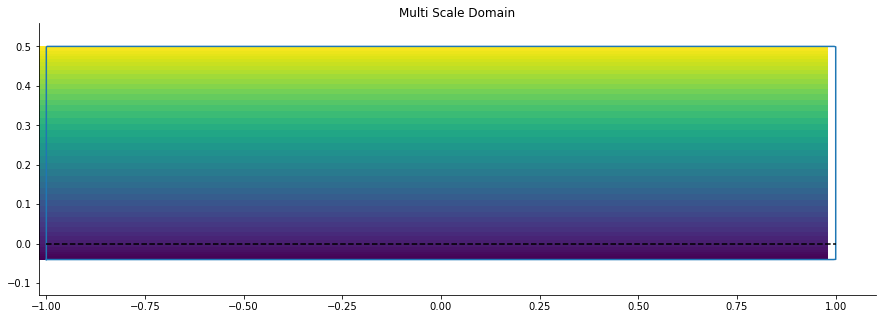

In [2]:
# Hard coded
eps = 0.04
dom = [[-1.,1.], [0, 0.5]]
bbox = [dom[0], [dom[1][0]-eps, dom[1][1]]]

# Not hard coded
Lx = dom[0][1] - dom[0][0]


# Fnctions
f = lambda x: np.zeros_like(x) - eps
df = lambda x: np.zeros_like(x)
ddf = lambda x: np.zeros_like(x)
g = lambda x: np.ones_like(x)

usol = lambda x,y: g(x) * (y - bbox[1][0]) /(bbox[1][1] - bbox[1][0])
dy_usol = lambda x,y: g(x) / (bbox[1][1] - bbox[1][0])
#usol = lambda x, y: uflat(x.flatten(), y.flatten()).reshape(x.size)
vsol = lambda x,y: np.zeros_like(x)
true_alpha = lambda x: -usol(x, np.zeros_like(x)) / dy_usol(x, np.zeros_like(x))

usol_basis = SSBasisProduct.fromFunctionInDomain(usol, bbox, 51, 51, FourBasis, ChebBasis)
vsol_basis = SSBasisProduct.fromFunctionInDomain(vsol, bbox, 51, 51, FourBasis, ChebBasis)

# Plot
data = StokesData(f, df, ddf, g, dom)
vmin, vmax= 0, .5
plt.figure(figsize=(15,5))
plt.title("Multi Scale Domain")
usol_basis.plot(plt.gca())
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])

## Coupling to Micro Domain

To couple the macro domain to the microscopic domain, we make use of the HMM framework.
We construct a set of evenly spaced micro problems based on the Stokes data. The macro problem is constructed with a pre-specified resolution in the x- and y-directions.

In [3]:
# Macro problem
xDim = 31
yDim = 23
iDeg = 13 #nMic*2 +1
macro = StokesMacProb(data, 
                      lambda x,a: trig_interp(x,a, iDeg, L=dom[0][1]-dom[0][0]),
                     alpha0 = true_alpha)

# Micro problems
nMic = 3
xPos = np.linspace(dom[0][0]+4*eps, dom[0][1]-4*eps, nMic)-2*eps
micros = [StokesMicProb(data, x, 2*eps, 2*eps, 0.00, deg_project = 6) for x in xPos]

# Hmm problem.
hmm_prob = StokesHMMProblem(macro, micros, data)

## Solving using HMM iterations

To solve the problem, we make use of a sequence of micro solvers, as well as a micro solver.

In [4]:
class Callback():
    def __init__(self, macro):
        self.N = 100
        self.x = np.linspace(dom[0][0],dom[0][1],self.N)
        self.macro = macro
        self.current_alpha = macro.alpha(self.x)
        self.diff = []
    
    def __call__(self, it, macro_sol, micro_sols):
        self.previous_alpha = self.current_alpha
        self.current_alpha = self.macro.alpha(self.x)
        self.diff.append(np.linalg.norm(self.previous_alpha - self.current_alpha) / self.N**0.5)
        plt.plot(self.current_alpha)
        
debug_cb = Callback(macro)

print("Precomputing...")
macro_solver = MacroSolver(xDim, yDim)
micro_solvers = [MicroSolver(m) for m in micros]
hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)
print("Done")

Precomputing...
Done


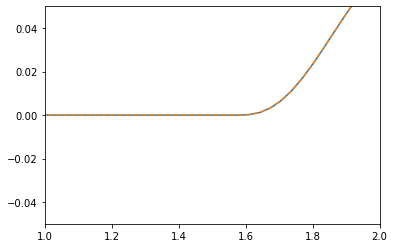

In [58]:
macro.alpha = true_alpha#lambda t: np.zeros_like(t)
macro_sol = macro_solver.solve(macro)
for m in micros: m.update(macro_sol)
    
    
m = micros[0]
t = np.linspace(0, 2*np.pi, 200)
z = m.geom.eval_param(t=t)
x, y = np.real(z), np.imag(z)
u_m = m.condition(t)
u_true = usol(x, y)

plt.plot(t, np.real(u_m))
plt.plot(t, np.real(u_true), '--')
plt.xlim([1,2])
plt.ylim([-0.05, 0.05])

#for m in micros: m.condition = lambda t: usol(np.real(m.geom.eval_param(t=t)), np.imag(m.geom.eval_param(t=t)))#m.update(macro_sol)
#micro_sols = [s.solve(m) for s,m in zip(micro_solvers, micros)]
#plt.plot(x, macro.alpha(x))
#plt.scatter([m.x for m in micro_sols], [m.alpha for m in micro_sols])

HMM Solver...
Step 14/15
Done


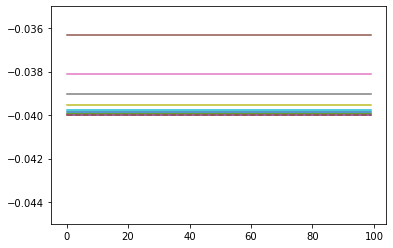

In [11]:
macro.alpha = lambda t: np.zeros_like(t)

print("HMM Solver...")
macro_guess = macro_solver.solve(macro)
macro_sol = macro_guess
#for i in range(10):
    #for m in micros: m.condition = lambda t: usol(np.real(m.geom.eval_param(t=t)), np.imag(m.geom.eval_param(t=t)))#m.update(macro_sol)
    #for m in micros: m.update(macro_sol, N=6)
    #micro_sols = [s.solve(m) for s,m in zip(micro_solvers, micros)]
    #macro.update(micro_sols)
    #macro_sol = macro_solver.solve(macro)
    #debug_cb(i, macro_sol, micro_sols)
(macro_sol, micro_sols) = hmm_solver.solve(hmm_prob, macro_guess=macro_guess, 
                                               callback=debug_cb, verbose=True, maxiter=15)

print("\nDone")
plt.plot(true_alpha(debug_cb.x), '--')
plt.ylim([-0.045, -0.035])

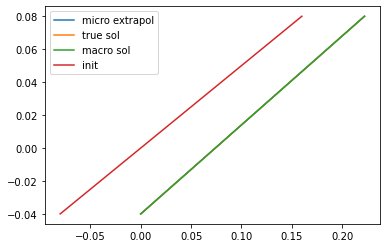

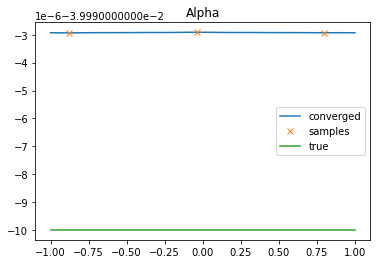

In [12]:
plt.figure()
cond = lambda t: np.real(micros[0].condition(t))
ycord = lambda t: np.imag(micros[0].geom.eval_param(t=t))
t = np.linspace(0,np.pi,100)
yc = ycord(t)
plt.plot(cond(t), yc, label='micro extrapol')
plt.plot(usol_basis(np.zeros_like(t), ycord(t)), yc, label='true sol')
plt.plot(macro_sol.u(np.zeros_like(t), ycord(t)), yc, label='macro sol')
plt.plot(macro_guess.u(np.zeros_like(t), ycord(t)), yc, label='init')
plt.legend()




plt.figure()
plt.title("Alpha")
x = np.linspace(dom[0][0],dom[0][1],100)
a = macro.alpha(x)
xm = np.array([sol.x for sol in micro_sols])
am = np.array([sol.alpha for sol in micro_sols])
plt.plot(x, a, label='converged')
plt.plot(xm, am, 'x', label='samples')
plt.plot(x, true_alpha(x), label='true')
plt.legend()


## Convergence study for slip coefficient

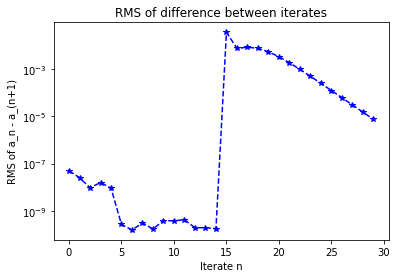

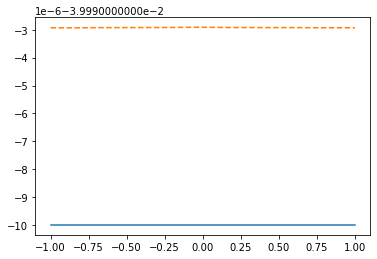

In [13]:
plt.figure()
plt.title("RMS of difference between iterates")
plt.semilogy(debug_cb.diff, 'b*--')
plt.xlabel("Iterate n")
plt.ylabel("RMS of a_n - a_(n+1)")

plt.figure()
x = np.linspace(dom[0][0], dom[0][1], 100)
plt.plot(x, true_alpha(x))
plt.plot(x, macro.alpha(x), '--')

## Prepare comparison
We use the reference solver data to construct a piecewise linear interpolation. Also, the micro data is used to construct a set of full solutions to the velocity field in the micro problems for visualisation purposes.

In [14]:
full_micro_sols = []
for m in micros:
    prob = StokesDirichletProblem(m.geom, m.condition)
    prob.solve()
    full_micro_sols.append(prob)

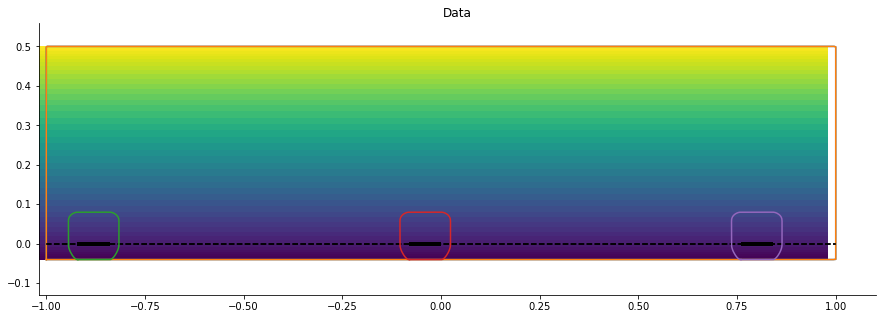

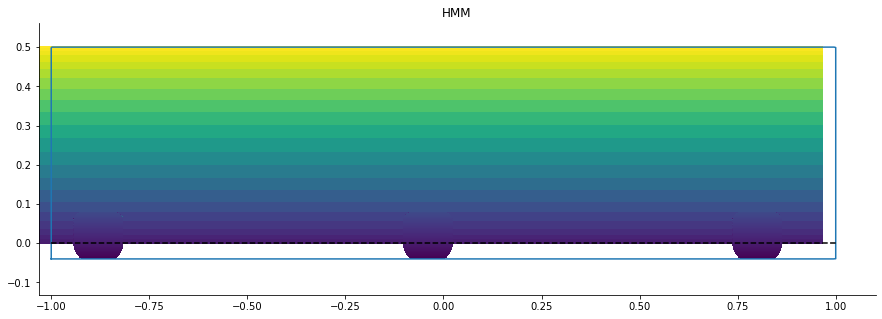

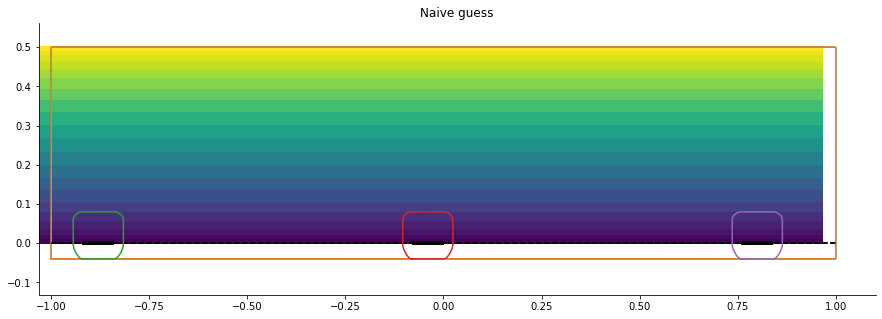

In [15]:
vmax, vmin = 1., 0.

plt.figure(figsize=(15,5))
plt.title("Data")
usol_basis.plot(plt.gca(), vmax=vmax, vmin=vmin)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
hmm_prob.plot(plt.gca())

plt.figure(figsize=(15,5))
plt.title("HMM")
macro_sol.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
for m, s in zip(micros, full_micro_sols):
    m.geom.plot_field(plt.gca(), lambda z: np.real(s.evaluate(z)), apply_mask=True, vmin=vmin, vmax=vmax)
#hmm_prob.plot(plt.gca(), color='black', linewidth=1)



plt.figure(figsize=(15,5))
plt.title("Naive guess")
macro_guess.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
hmm_prob.plot(plt.gca(), color='black', linewidth=1)

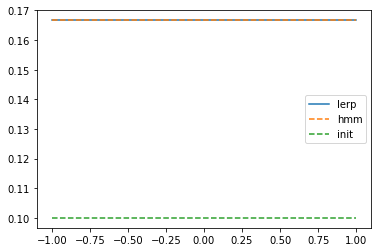

In [16]:
plt.figure()
#yfix = dom[1][1]-np.ones_like(xhd)*0.02
xhd = np.linspace(-1,1,100)
yfix = np.ones_like(xhd)*0.05
#plt.plot(xmac, Umac[53,:], label='true')
plt.plot(xhd, usol_basis(xhd, yfix), label='lerp')#, linestyle='--')
plt.plot(xhd, macro_sol.u(xhd, yfix), linestyle='--', label='hmm')
plt.plot(xhd, macro_guess.u(xhd, yfix), linestyle='--', label='init')

plt.legend()

# a f(x) + b = g(x)
# a f(y) + b = g(y)
# a = (g(x) - g(y)) / (f(x) - f(y))
#x1 = np.array([0.2,0.4])
#y1 = np.zeros_like(x1) + 0.1
#f = pwlerp(x1, y1)
#g = macro_sol.u(x1, y1)

#a = (g[0]-g[1]) / (f[0] - f[1])
#b = g[0] - a*f[1]
#print(b)


Verifying derivatives

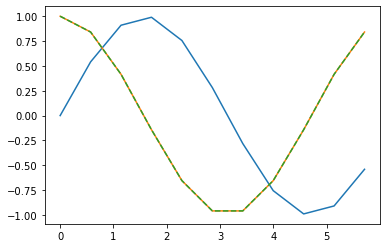

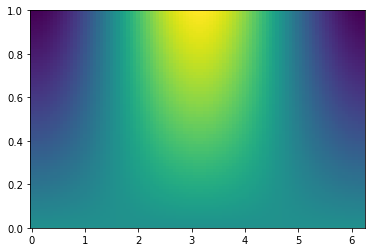

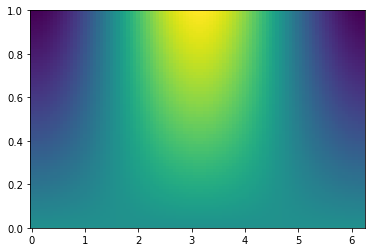

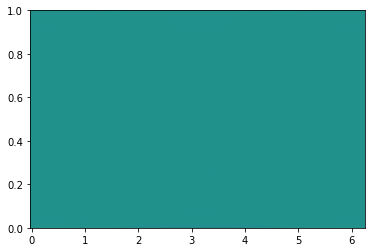

In [17]:
f = lambda x: np.sin(x)
df = lambda x: np.cos(x)

basis = SSBasis.fromFunction(f, 2*np.pi, 0, FourBasis, 11)
dbasis = SSBasis.fromFunction(df, 2*np.pi, 0, FourBasis, 11)
#basis = FourBasis.fromFunction(f, 11)


basis.plot(plt.gca(), 11)
dbasis.plot(plt.gca(), 11)
basis.diff(1).plot(plt.gca(), 11, linestyle='--')


#f = lambda x,y: np.sin(2*np.pi*x)*np.cos(2*np.pi*y)
f = lambda x,y: np.sin(x)*np.cos(y)
dx_f = lambda x,y: np.cos(x)*np.cos(y)
dxy_f = lambda x,y: -f(y,x)
scale = [2*np.pi,1.]
shift = [0.,0.]

#help(ScaleShiftedBasisProduct)
basis = SSBasisProduct.fromFunctionInDomain(f, [[0,2*np.pi], [0,1]], 
                                    101, 101, FourBasis, ChebBasis)
#basis = BasisProduct.fromFunction(f, 101, 101, FourBasis, ChebBasis)
dx_basis = basis.diff(1, 1)

plt.figure()
dx_basis.plot(plt.gca())


X, Y = basis.grid()
plt.figure()
plt.pcolormesh(X, Y, dxy_f(X,Y))

plt.figure()
plt.pcolormesh(X,Y,dxy_f(X,Y)-
               dx_basis.eval_grid())
